In [1]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi
import json
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import networkx as nx

# Imports for working with shapefiles
import pyproj
from shapely.geometry import shape, MultiPolygon, mapping
from shapely.ops import transform, cascaded_union
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib import cm
from matplotlib.patches import Polygon
%matplotlib inline

In [2]:
wisc_census_blocks = 'data/block_groups/shapes/tl_2013_55_bg.shp'

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

In [3]:
poptot_df = pd.read_csv('data/block_groups/pop_tot/DEC_10_SF1_P1_with_ann.csv')
poptot_df = poptot_df[['GEO.id2', 'D001']]
poptot_df.columns = ['geoid', 'poptot']
poptot_df.drop(0, axis=0, inplace=True)
poptot_df.set_index('geoid', inplace=True)

pop18_df = pd.read_csv('data/block_groups/pop18/DEC_10_SF1_P10_with_ann.csv')
pop18_df = pop18_df[['GEO.id2', 'D001', 'D003']]
pop18_df.columns = ['geoid', 'pop18', 'pop18wht']
pop18_df.drop(0, axis=0, inplace=True)
pop18_df.set_index('geoid', inplace=True)

In [4]:
with fiona.open(wisc_census_blocks) as f:
    blocks = [
        {
            'shape': transform(project, shape(block['geometry'])), 
            'geoid': block['properties']['GEOID'],
            'untransformed': shape(block['geometry'])
        }
        for block in f
    ]

In [5]:
for block in blocks:
    block['centroid'] = np.array([coord[0] for coord in block['shape'].centroid.xy])
    block['pop18'] = int(pop18_df.loc[block['geoid']]['pop18'])
    block['pop18wht'] = int(pop18_df.loc[block['geoid']]['pop18wht'])
    block['poptot'] = int(poptot_df.loc[block['geoid']]['poptot'])

In [6]:
coord_array = np.array([block['centroid'] for block in blocks])
weight_array = np.array([block['poptot'] for block in blocks])

In [7]:
model = KMeans(n_clusters=8, max_iter=1e6, n_jobs=-1, tol=1e-11)

In [8]:
labels = model.fit_predict(coord_array)

In [9]:
for label, block in zip(labels, blocks):
    block['label'] = int(label)

In [10]:
districts = [{} for i in range(8)]
for label in range(8):
    districts[label]['shape'] = cascaded_union([block['shape'] for block in blocks if block['label'] == label])
    
    districts[label]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

In [13]:
wisc_pop = np.sum([block['poptot'] for block in blocks])
ideal_dist_pop = wisc_pop/8

for label in range(8):
    _tot_pop = np.sum([block['poptot'] for block in blocks if block['label'] == label])
    districts[label]['poptot'] = _tot_pop
    
    _tot_pop18 = np.sum([block['pop18'] for block in blocks if block['label'] == label])
    districts[label]['pop18'] = _tot_pop18
    
    _tot_pop18wht = np.sum([block['pop18wht'] for block in blocks if block['label'] == label])
    districts[label]['pop18wht'] = _tot_pop18wht
    
    _area = districts[label]['shape'].area/(1000)**2
    _perimeter = districts[label]['shape'].length/1000
    districts[label]['compactness'] = (4*pi*_area/_perimeter**2)
    
    _pop_diff = _tot_pop - ideal_dist_pop
    districts[label]['popdiff'] = _pop_diff/ideal_dist_pop
    
print(ideal_dist_pop, _tot_pop)

710873.25 444261


In [14]:
for i, district in enumerate(districts):
    print('Population of District {}: {}'.format(i, district['poptot']))

Population of District 0: 476630
Population of District 1: 2029343
Population of District 2: 466486
Population of District 3: 355662
Population of District 4: 444261
Population of District 5: 983785
Population of District 6: 134445
Population of District 7: 796374


In [12]:
with fiona.open('data/districts/congressional/Wisconsin_Congressional_Districts.shp') as f:
    current_districts = [
        {
        'shape': transform(project, shape(district['geometry'])),
        'untransformed': shape(district['geometry'])
        }
        for district in f
    ]
    wisconsin = cascaded_union([transform(project, shape(district['geometry'])) for district in f])
    wisc_untrans = cascaded_union([shape(district['geometry']) for district in f])

In [15]:
wisc_untrans.bounds

(-92.8894329062527, 42.49191474914349, -86.76398658736599, 47.08077430717272)

In [16]:
def generate_colors(values, cmap, reference=1):
    _colors = [cmap(value/reference) for value in values]
    
    return _colors

In [17]:
def plot_shapes(
        shapelist, shape_colors, alpha=0.85, fig_file=None,
        center_of_mass_arr=None):
    _patches = [
        PolygonPatch(shape['shape'].intersection(wisconsin))
        for shape in shapelist
    ]
    
    for patch, color in zip(_patches, cycle(shape_colors)):
        patch.set_facecolor(color)
        patch.set_linewidth(1.5)
        patch.set_alpha(alpha)
        
    fig, ax = plt.subplots()
    
    fig.patch.set_alpha(0.0)

    for patch in _patches:
        ax.add_patch(patch)
        
    if center_of_mass_arr is not None:
        ax.plot(center_of_mass_arr[:,0], center_of_mass_arr[:,1])

    ax.relim()
    ax.autoscale_view()
    ax.axis('off')
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    aspect_ratio = (ymax - ymin)/(xmax - xmin)
    x_size = 20
    fig.set_size_inches((x_size, x_size*aspect_ratio))
    
    if fig_file:
        try:
            fig.savefig(fig_file, bbox_inches='tight')
        except IOError as e:
            raise(e)
            
    return None

In [217]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
district_colors = [to_rgb(color) for color in hex_colors]

kmeans_file = 'images/naive_kmeans_districts.png'
plot_shapes(districts, district_colors, fig_file=kmeans_file)

NameError: global name 'wisconsin' is not defined

In [20]:
crs = from_epsg(4326)
schema = {
    'geometry': 'Polygon',
    'properties': {
        'id': 'int', 'cmpctness': 'float', 'poptot': 'int',
        'pop18': 'int', 'pop18wht': 'int', 'popdiff': 'float'
    }
}
with fiona.open('data/districts/generated/kmeans', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    for i, district in enumerate(districts):
            c.write({
                'geometry': mapping(district['untransformed'].intersection(wisc_untrans)),
                'properties': {
                    'id': i+1, 
                    'cmpctness': district['compactness'],
                    'poptot': district['poptot'],
                    'pop18': district['pop18'],
                    'pop18wht': district['pop18wht'],
                    'popdiff': district['popdiff']
                }
            })

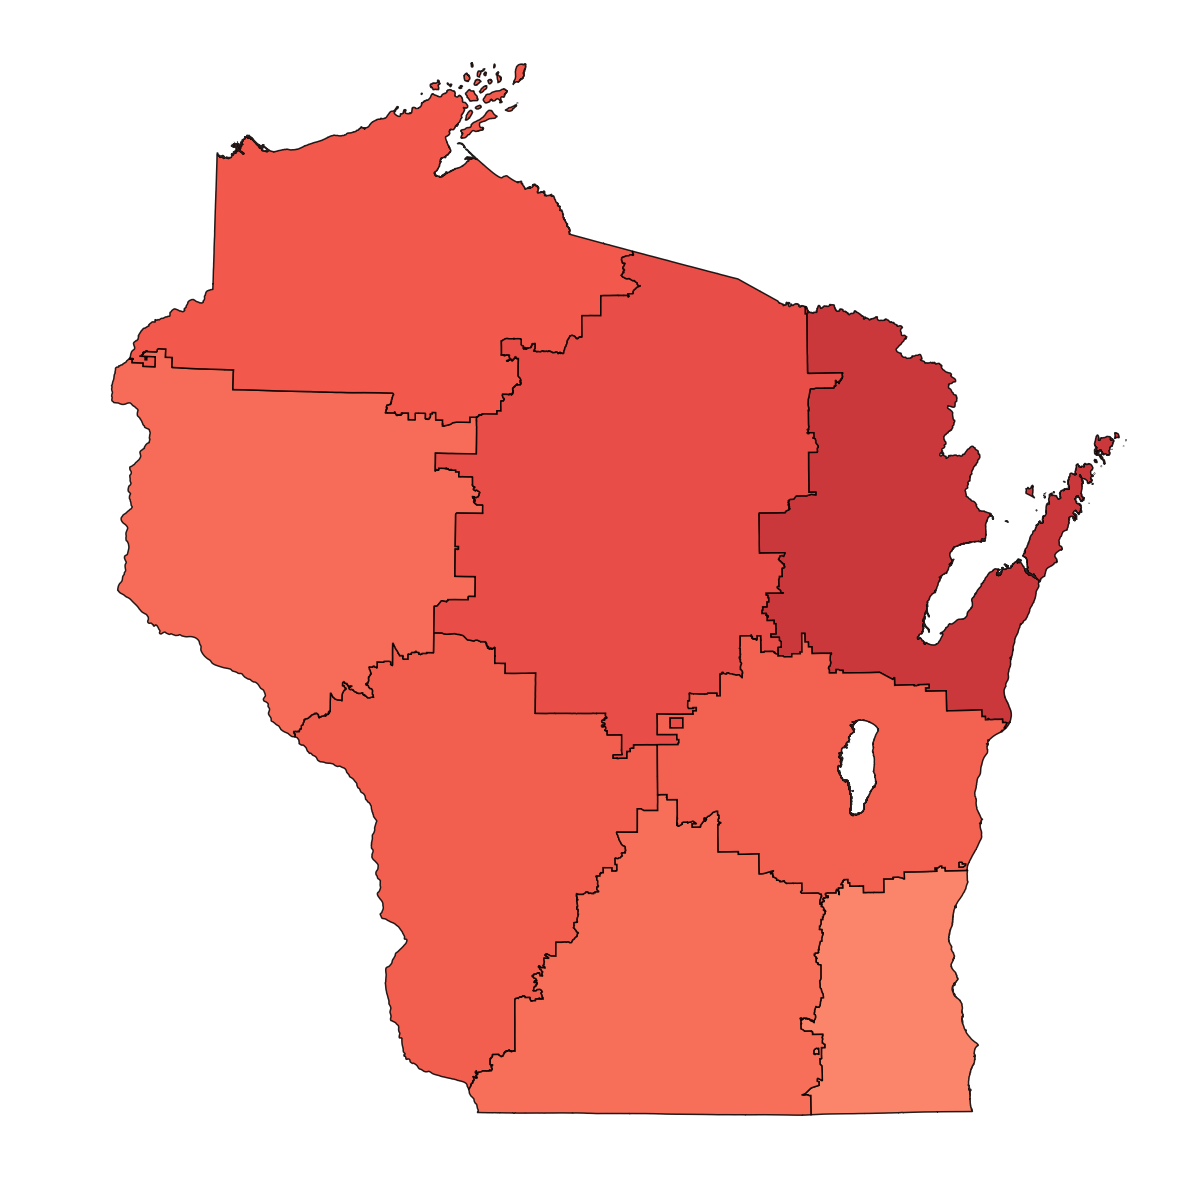

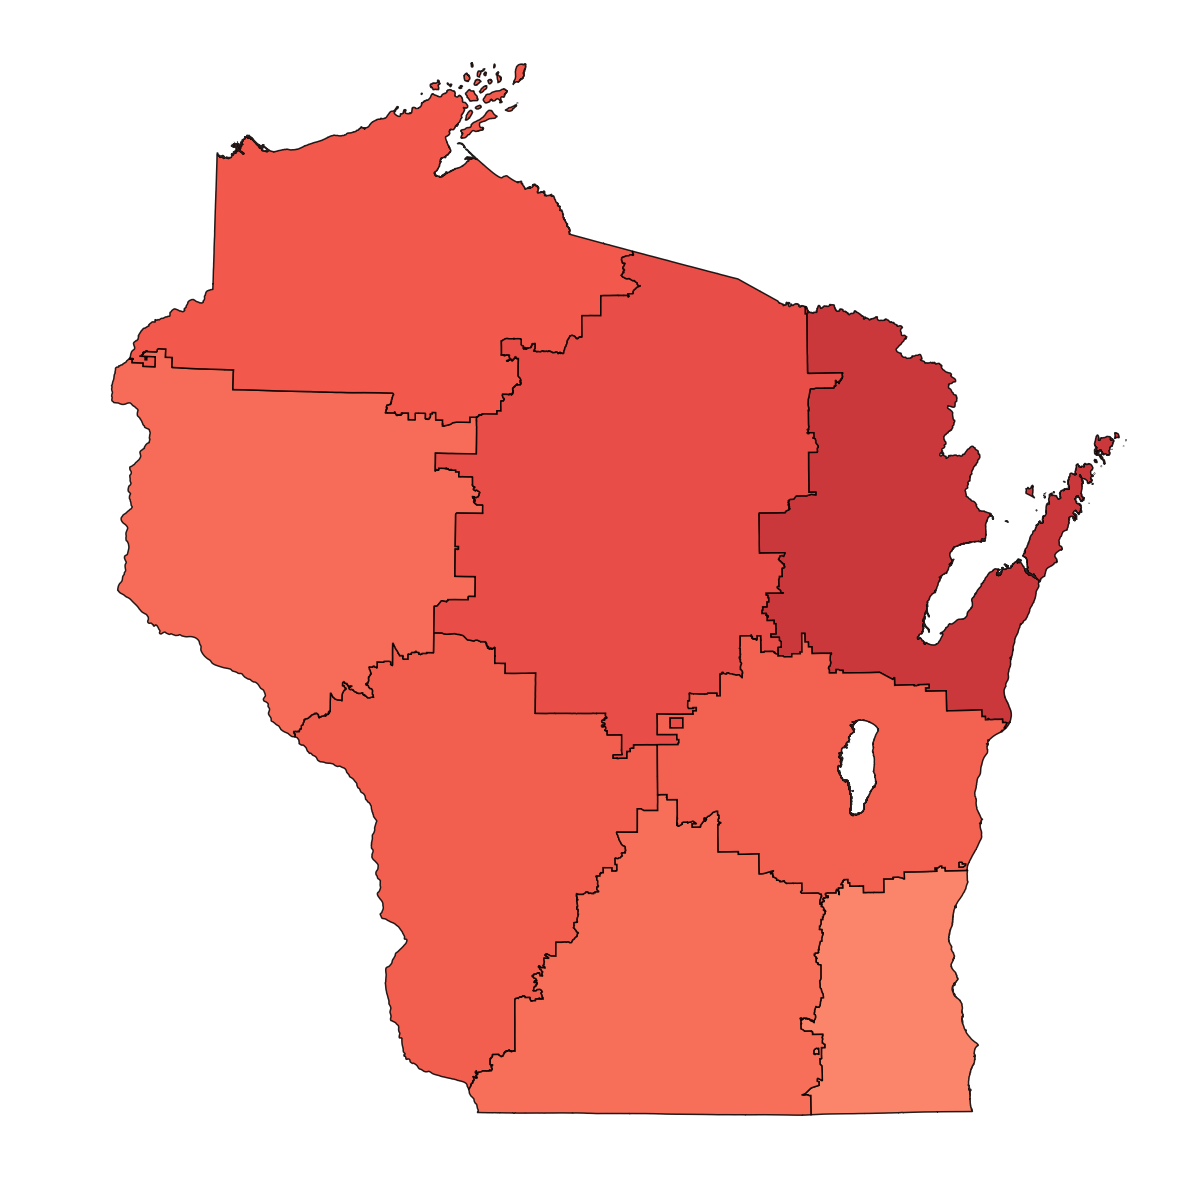

In [21]:
ref_aspect = 1.5
reference = 4*pi*(ref_aspect)/(2*(1+ref_aspect))**2
cmpct_values = [dis['compactness'] for dis in districts]
cmpct_colors = generate_colors(cmpct_values, cm.Reds_r, reference=reference)

plot_shapes(districts, cmpct_colors)

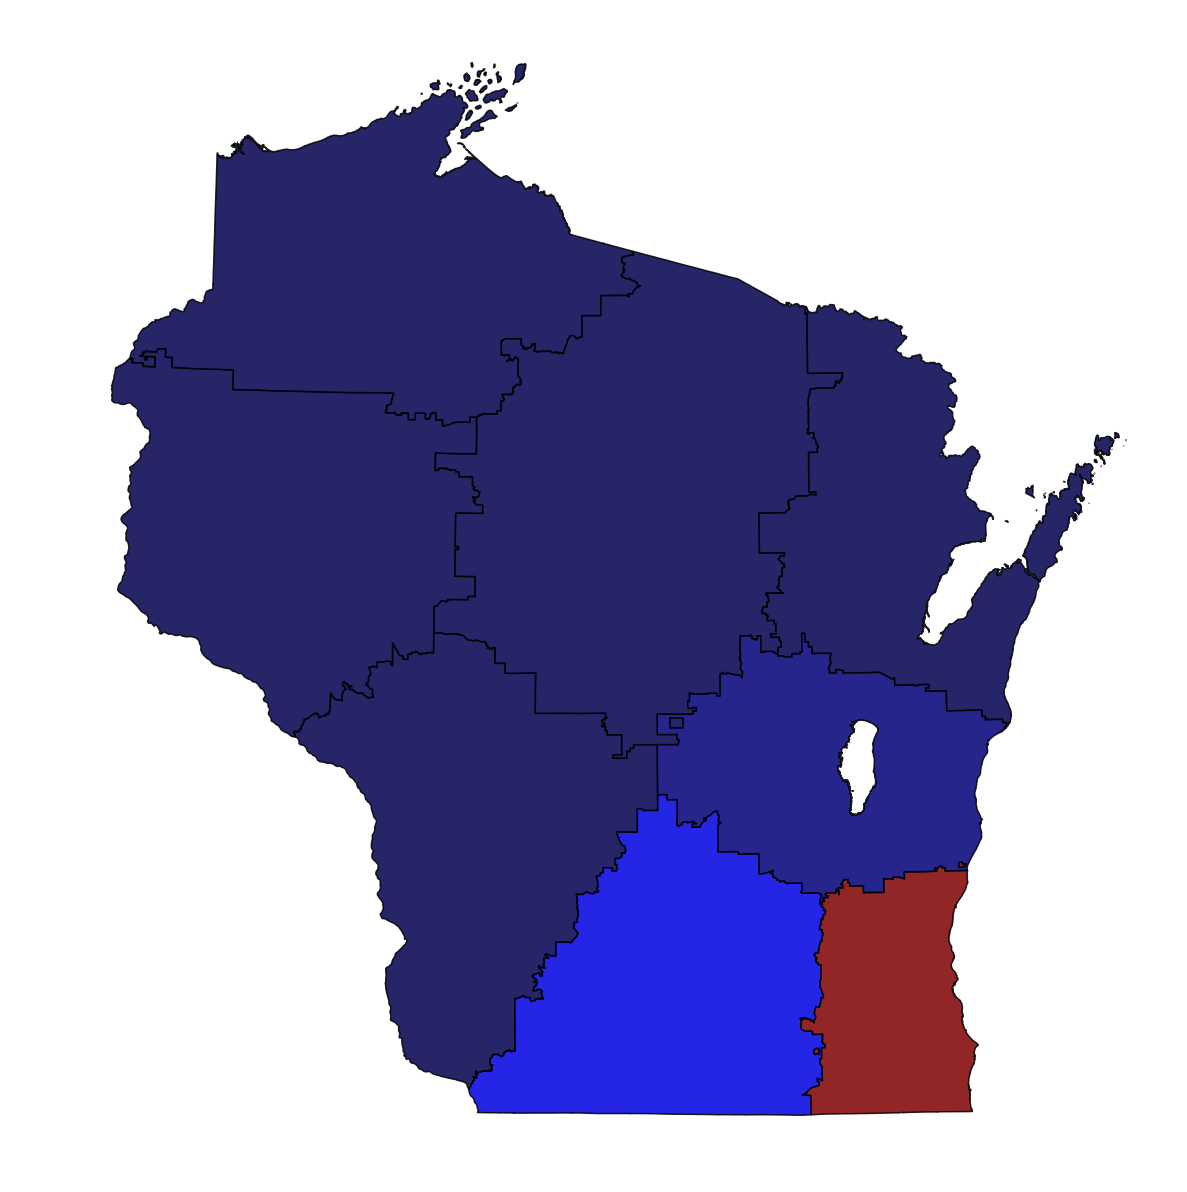

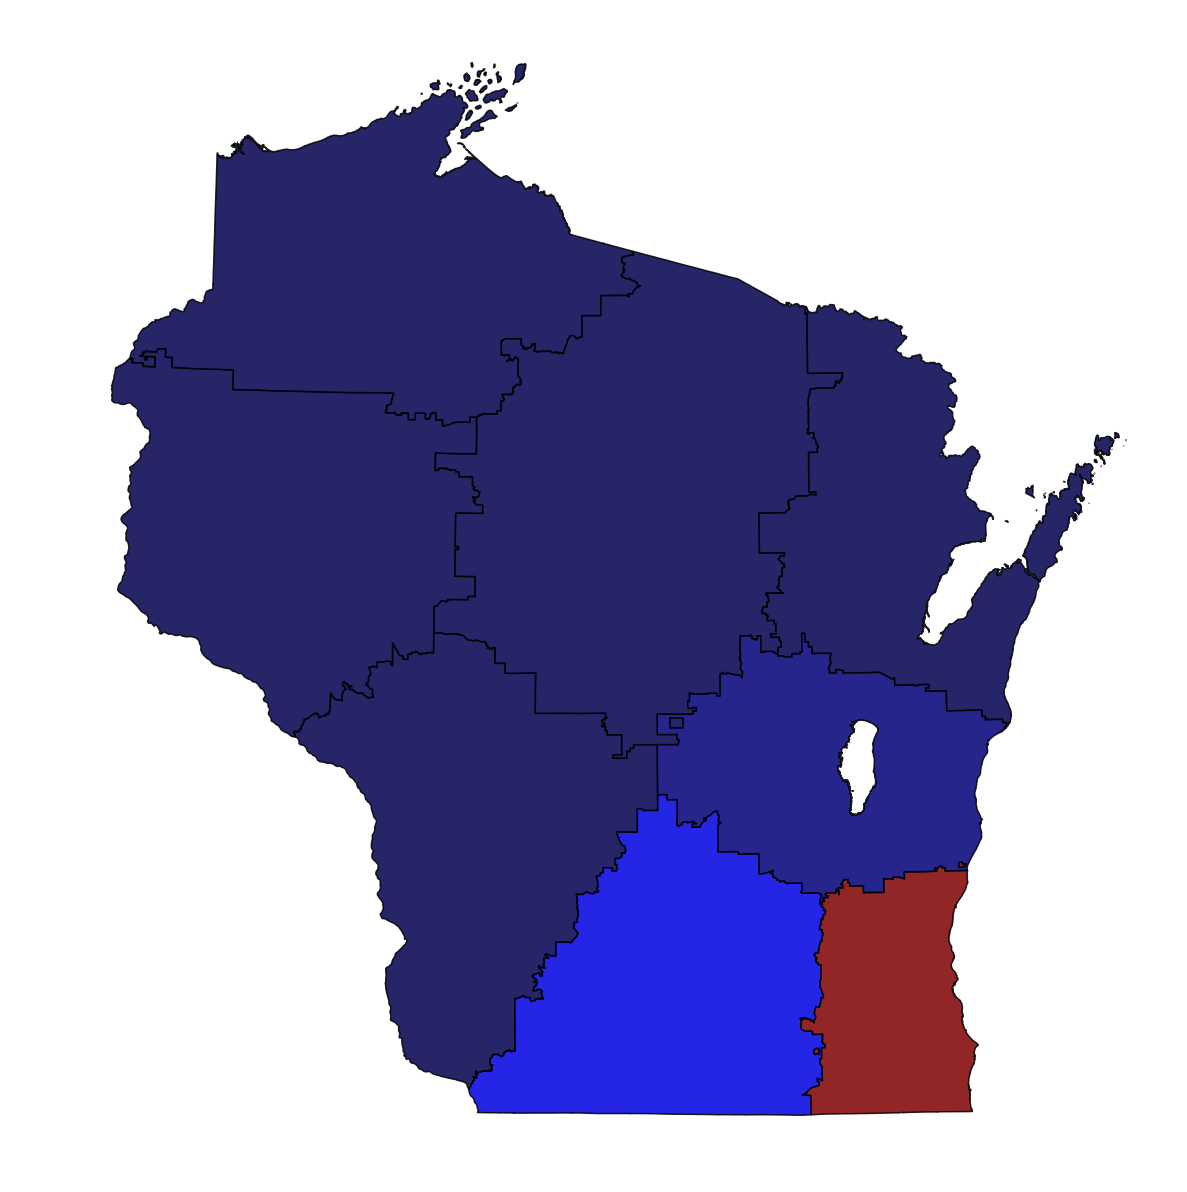

In [23]:
signed_vars = [district['popdiff'] for district in districts]
var_colors = generate_colors(signed_vars, cm.seismic, reference=max(np.abs(signed_vars)))

plot_shapes(districts, var_colors)

In [24]:
with fiona.collection("data/districts/generated/kmeans/kmeans.shp", "r") as source:
    features = [feature for feature in source]
    crs = " ".join("+{}={}".format(key,value) for key, value in source.crs.items())
    
for feature in features:
    feature['geometry'] = mapping(
        shape(feature['geometry']).simplify(4e-3)
    )

In [26]:
my_layer = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {
        "type": "link", 
        "properties": {"href": "kmeans_districts.crs", "type": "proj4"}
    }
}

with open("src/static/geojson/kmeans_districts.json", "w") as f:
    f.write(unicode(json.dumps(my_layer)))
with open("src/static/geojson/kmeans_districts.crs", "w") as f:
    f.write(unicode(crs))

In [376]:
class SameSizeKMeans(object):
    '''K-Means clustering
    
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
    
    weight_tol : float, default: 1e-4
        Fractional tolerance of the 
        
    init_model: KMeans object, default: None
        The initial KMeans model to fit on. Leaving as None
        defaults to KMeans with default parameters except for
        passing the as-specified n_clusters.
        
    save_labels: bool, default: False
        Whether to save labels at each step of the fitting
        process. Setting to True will cause the creation
        
    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Final coordinates of cluster centers
    
    labels_ :
        Final labels of each point
        
    all_labels_:
        Labels of each point at each step of the fitting
        process. None unless save_labels is set to True.
    
    '''
    
    LOOP_BUFFER = 1
    ORDER_DICT = {
        'largest_first': 'l',
        'smallest_first': 's',
        'l': 'l',
        's': 's',
        'min_v': 'min_v',
        'max_v': 'max_v'
    }
    
    def __init__(self, n_clusters=8, init_model = None,
                 save_labels=True, metric='l2',
                 distance_array=None):
        self.n_clusters = n_clusters
        if init_model is None:
            self.init_model = KMeans(n_clusters=n_clusters)
        else:
            self.init_model = init_model
        self.init_params = self.init_model.get_params()
        self.save_labels = save_labels
        if save_labels:
            self.all_labels_ = []
        else:
            self.all_labels_ = None
        self.metric = metric
        self.distance_array
    
    def fit(self, X, weights=None, weight_tol=0, order='largest_first'):
        
        self._save_fit_params(X, weights, weight_tol, order)
        
        # Get temporary labels from a naive KMeans clustering
        _temp_labels = self._fit_naive_KMeans(X)
        
        for step in range(self.n_clusters - self.LOOP_BUFFER):
            
            print('Starting step ',step)
            
            # Determine the cluster to update on this step, along
            # with its associated info
            _coords, _weights, _label, _score_arr, _centroid = (
                self._get_cluster_info(order, step)
            )

            # Adjust the determined cluster, and return its finalized
            # associated coordinates
            _coords = self._adjust_cluster(
                _coords, _weights,
                _label, _score_arr,
                order, step)
            
            # Set _coords as having finalized labels, and set their labels
            for coord in _coords:
                _mask = np.isclose(self.X, coord).all(1)
                self._labels_finalized[_mask] = True
                self.final_labels[_mask] = _label
            
            # Remove _label from the list of unfinalized clusters
            self._clusters_unfinalized = [
                label for label in self._clusters_unfinalized
                if label != _label
            ]
            
            # Update centroids
            self._update_centroids()
            
            if self.save_labels:
                self.all_labels_.append(self.final_labels)
    
    def _save_fit_params(self, X, weights, weight_tol, order):
        
        self.X = X
        self.weight_tol = weight_tol
        
        if weights is None:
            self.weights = np.ones(X.shape[0])
        else:
            try:
                assert(weights.shape[0] == X.shape[0])
                self.weights = weights                    
            except AssertionError:
                raise AssertionError('X and weights are not the same length')
        
        self._ideal_cluster_weight = np.sum(weights)/self.n_clusters    
    
    def _fit_naive_KMeans(self, X):
        
        # Setup naive KMeans model
        _temp_model = KMeans(**self.init_params)

        # Get labels from KMeans model, and save them if desired
        _temp_labels = _temp_model.fit_predict(X)
        self._unique_labels = np.unique(_temp_labels)
        if self.save_labels:
            self.all_labels_.append(_temp_labels)
            
        # Create a dictionary of cluster centers by label
        self.cluster_centers_ = {
            label: np.mean(X[_temp_labels == label], axis=0)
            for label in self._unique_labels
        }
            
        # Create a dictionary of centers of mass by label
        self.cluster_centers_ = {
            label: np.mean(X[_temp_labels == label], axis=0)
            for label in self._unique_labels
        }
        
        # Save the current labels as the final labels. To be
        # updated as the program progresses.
        self.final_labels = deepcopy(_temp_labels)
        
        # Numpy array specifying whether the point is finalized
        # according to its assignment. Updated accordingly later.
        self._labels_finalized = np.array([False for coords in X])
        
        # List of unfinalized clusters
        self._clusters_unfinalized = [label for label in self._unique_labels]
            
        return _temp_labels
    
    def _get_cluster_info(self, order, step):
        
        _order = self._get_order(order, step)
        
        # Find the coordinates, weights, and label of the cluster
        # determined by order.
        _coords, _weights, _label = self._find_cluster(_order)
        _centroid = self.cluster_centers_[_label]
        
        if _order == 'l':
            _score_arr = None
        elif _order == 's':
            _score_arr = self._score_other_points(
                _coords, _centroid
            )
        elif _order == 'min_v':
            if np.sum(_weights) > self._ideal_cluster_weight:
                _score_arr = None
            else:
                _score_arr = self._score_other_points(
                    _coords, _centroid
                )
        elif _order == 'max_v':
            if np.sum(_weights) > self._ideal_cluster_weight:
                _score_arr = None
            else:
                _score_arr = self._score_other_points(
                    _coords, _centroid
                )
        
        return(_coords, _weights, _label, _score_arr, _centroid)
    
    def _get_order(self, order, step):
        
        try:
            _order = self.ORDER_DICT[order]
        except KeyError:
            raise KeyError(
                'order must be one of: {}'.format(
                    self.ORDER_DICT.keys())
            )
        except TypeError:
            try:
                _order = self.ORDER_DICT[order[step]]
            except KeyError:
                raise KeyError(
                    'order must be one of: {}'.format(
                        self.ORDER_DICT.keys())
                )
            except TypeError:
                raise TypeError('Order must be a string or list of strings.')
                
        return _order
    
    def _find_cluster(self, order):
        '''Finds the unfinalized cluster according to order'''
        
        # Find the coordinates, weights, and current assigned
        # label of each point which doesn't have a finalized
        # cluster
        _X = self.X[
            np.logical_not(self._labels_finalized)
        ]
        _temp_weights = self.weights[
            np.logical_not(self._labels_finalized)
        ]
        _labels = self.final_labels[
            np.logical_not(self._labels_finalized)
        ]
        
        # Get the weights of the clusters that aren't finalized
        # if order is 'l' or 's'
        if (order == 'l' or order == 's'):
            _label_weights = {
                label: np.sum(_temp_weights[_labels == label])
                for label in self._clusters_unfinalized
            }
        # Get the distance of weights of the clusters from the
        # ideal cluster weight for the clusters that aren't
        # finalized if order is 'min_v' or 'max_v'
        elif (order == 'min_v' or order == 'max_v'):
            _label_weights = {
                label: abs(
                    np.sum(_temp_weights[_labels == label])
                    - self._ideal_cluster_weight
                )
                for label in self._clusters_unfinalized
            }
        
        if order == 'l':
            # Find the label of the largest unfinalized cluster
            _cluster = max(_label_weights, key=_label_weights.get)
        elif order == 's':
            # Find the label of the smallest unfinalized cluster
            _cluster = min(_label_weights, key=_label_weights.get)
        elif order == 'min_v':
            # Find the label of the cluster closest to the optimal size
            _cluster = min(_label_weights, key=_label_weights.get)
        elif order == 'max_v':
            # Find the label of the cluster farthest from the optimal size
            _cluster = max(_label_weights, key=_label_weights.get)
            
        _coords = _X[_labels == _cluster]
        _weights = _temp_weights[_labels == _cluster]
        
        return(_coords, _weights, _cluster)
    
    def _adjust_cluster(self, coords, weights, label,
                        score_arr, order, step):
    
        _order = self._get_order(order, step)
        
        # Check if the cluster has the right total weight by comparing it
        # to the ideal cluster weight and the specified weight tolerance.
        # If it doesn't, find the point farthest from the center of mass,
        # and reassign it. Repeat until satisfied.
        while (
                abs(np.sum(weights) - self._ideal_cluster_weight)
                / self._ideal_cluster_weight > self.weight_tol):

            if _order == 'l':
                coords, weights = self._reassign_farthest(
                    coords, weights, label)
            elif _order == 's':
                coords, weights, score_arr = (
                    self._reassign_closest(
                        coords, weights, label, score_arr)
                )
            elif _order == 'min_v':
                if np.sum(weights) > self._ideal_cluster_weight:
                    coords, weights = self._reassign_farthest(
                        coords, weights, label)
                else:
                    coords, weights, score_arr = (
                        self._reassign_closest(
                            coords, weights, label, score_arr)
                    )
            elif _order == 'max_v':
                if np.sum(weights) > self._ideal_cluster_weight:
                    coords, weights = self._reassign_farthest(
                        coords, weights, label)
                else:
                    coords, weights, score_arr = (
                        self._reassign_closest(
                            coords, weights, label, score_arr)
                    )
                
        return(coords)
    
    def _score_centroids_one_point(self, coords, label):
        '''Gets distance between point and remaining clusters'''
        
        point_dict = {
            _label: self._calculate_distance(coords)
            for _label in self._clusters_unfinalized
            if _label != label
        }
        
        return point_dict
    
    def _reassign_farthest(self, coords, weights, label):
            
        # Calculated the cluster's current center of mass
        center_of_mass = (
            np.sum(weights[:, None]*coords, axis=0)
            / np.sum(weights)
        )[None, :]
                           
        # Reassign this cluster's center to the center of mass
        self.cluster_centers_[label] = center_of_mass
        
        # Find the squared distances of the points to the center
        # of mass of the cluster, and find the point farthest
        _sqrd_dists = np.sum((coords - center_of_mass)**2, axis=1)
        _farthest_point_ind = np.argmax(_sqrd_dists)
        _farthest_point_dist = _sqrd_dists[_farthest_point_ind]
        _farthest_point = coords[_sqrd_dists == _farthest_point_dist]
        
        # Score the unfinalized centroids that are not from
        # the current cluster on the farthest point, then
        # find the best cluster for that point
        _centroid_scores = self._score_centroids_one_point(
            _farthest_point, label)
        _best_cluster = min(
            _centroid_scores, key=_centroid_scores.get)
        
        # Reassign the label in the final_label array
        _full_point_mask = np.isclose(self.X, _farthest_point).all(1)
        self.final_labels[_full_point_mask] = _best_cluster
        
        # Remove the farthest point from the current coordinate
        # and weight array
        _point_mask = (_sqrd_dists != _farthest_point_dist)
        _coords = coords[_point_mask]
        _weights = weights[_point_mask]
        
        return(_coords, _weights)
    
    def _score_other_points(self, coords, centroid):
        
        # Make a mask for each point in coords that tells us
        # if it's in X
        _coords_masks = [
            np.isclose(self.X, coord).all(1)
            for coord in coords
        ]
        
        # Sum all the masks, and negate the result to obtain
        # a mask for only those points not in coords, then
        # use it to obtain an array of only those points
        _other_points_mask = np.logical_not(
            np.sum(_coords_masks, axis=0).astype(np.bool)
        )
        _other_points = self.X[np.logical_and(
            np.logical_not(self._labels_finalized),
            _other_points_mask
        )]
        
        # Make an array where the first column is the point
        # being considered, and the 2nd column is the squared
        # distance to the specified centroid
        score_arr = np.array([
            [point, np.sum((point - centroid)**2)]
            for point in _other_points
        ])
        
        return score_arr
    
    def _reassign_closest(
            self, coords, weights, label, score_arr):
        
        # Select the closest point
        _best_score_row = np.argmin(score_arr[:,1])
        _best_point = score_arr[_best_score_row][0]
                
        # Remove the closest point from score_arr to pass it out
        # of the function
        _score_arr = np.delete(score_arr, (_best_score_row), axis=0)
        
        # Reassign the label in the final_label array, and get
        # the weight of the best point
        _best_point_mask = np.isclose(self.X, _best_point).all(1)
        self._labels_finalized[_best_point_mask] = True
        self.final_labels[_best_point_mask] = label
        _best_weight = self.weights[_best_point_mask]
        
        # Add the best point to the _coords and _weights arrays
        _coords = np.vstack((coords, _best_point))
        _weights = np.append(weights, _best_weight)
        
        return(_coords, _weights, _score_arr)
    
    def _update_centroids(self):
        
        # Create a dictionary of cluster centers by label
        self.cluster_centers_ = {
            label: np.mean(
                self.X[self.final_labels == label], axis=0)
            for label in self._unique_labels
        }
        
        return None
    
    def _calculate_distance(coord_arr, point=None):
        
        if coord_arr.ndim == 1:
            _axis = 0
        else:
            _axis = 1
            
        if point is None:
            _point = 0
        else:
            _point = point
        
        if self.metric == 'l2':
            _distances = np.sum(
                (coord_arr - _point)**2, axis=_axis)
        elif self.metric == 'l1':
            _distances = np.sum(
                np.abs(coord_arr - _point), axis=_axis)
        elif self.metric == 'l_inf':
            _distances = np.max(
                np.abs(coord_arr - _point), axis=_axis)
        elif self.metric == 'graph':
            raise NotImplementedError('Graph metrics not supported yet. Use l1, l2, or l_inf.')
            _ = find_nearest(self.X, point)
            _distances = None
    

def find_nearest(coord_arr, point):
    idx = np.abs(coord_arr - point).argmin()
    return{'dist': coord_arr[idx], 'idx': idx}


In [340]:
sskmeans = SameSizeKMeans(n_clusters=8, save_labels=True)

In [341]:
sskmeans.fit(
    coord_array, weights=weight_array,
    weight_tol=2e-3, order=['s', 'l', 'l', 's', 's', 's', 's', 's'])

Starting step  0
Starting step  1
Starting step  2
Starting step  3
Starting step  4
Starting step  5
Starting step  6


In [381]:
labels = sskmeans.final_labels
for label, block in zip(labels, blocks):
    block['label'] = int(label)
    block['iscontiguous'] = False

In [367]:
for label in np.unique(labels):
    _label_pop = np.sum(
        [block['poptot'] for block in blocks if block['label'] == label])
    print('Population of district {}: {}'.format(label, _label_pop))

Population of district 0: 710856
Population of district 1: 709551
Population of district 2: 713860
Population of district 3: 710837
Population of district 4: 711098
Population of district 5: 710777
Population of district 6: 710491
Population of district 7: 709516


In [368]:
dist_blocks = {
    label: [block for block in blocks
            if block['label'] == label]
    for label in np.unique(labels)
}
len(dist_blocks)

8

In [403]:
def cleanup_blocks(blocks, labels):
    
    dist_blocks = {
    label: [block for block in blocks
            if block['label'] == label]
    for label in np.unique(labels)
    }
    
    for label in dist_blocks:
        print(label)
        _blocks = dist_blocks[label]
        for block in _blocks:
            if block['iscontiguous']:
                continue
            for other_block in _blocks:
                if block['geoid'] != other_block['geoid']:
                    if block['shape'].touches(other_block['shape']):
                        block['iscontiguous'] = True
                        other_block['iscontiguous'] = True
                        break
                    else:
                        block['iscontiguous'] = False
    
    for block in blocks:
        votes = defaultdict(int)
        if block['iscontiguous']:
            continue
        for other_block in blocks:
            if other_block['geoid'] == block['geoid']:
                continue
            if other_block['shape'].touches(block['shape']):
                votes[other_block['label']] +=1
        preferred_label = max(votes, key=votes.get)
        block['label'] = preferred_label
        block['iscontiguous'] = True

In [404]:
cleanup_blocks(blocks, labels)

0
1
2
3
4
5
6
7


In [405]:
for block in blocks:
    if not block['iscontiguous']:
        print(block['geoid'])

In [347]:
new_districts = [{} for label in np.unique(labels)]
for i, label in enumerate(np.unique(labels)):
    new_districts[i]['shape'] = cascaded_union(
        [block['shape'] for block in blocks if block['label'] == label]
    )
    
    new_districts[i]['untransformed'] = cascaded_union([
        block['untransformed']
        for block in blocks
        if block['label'] == label
    ])

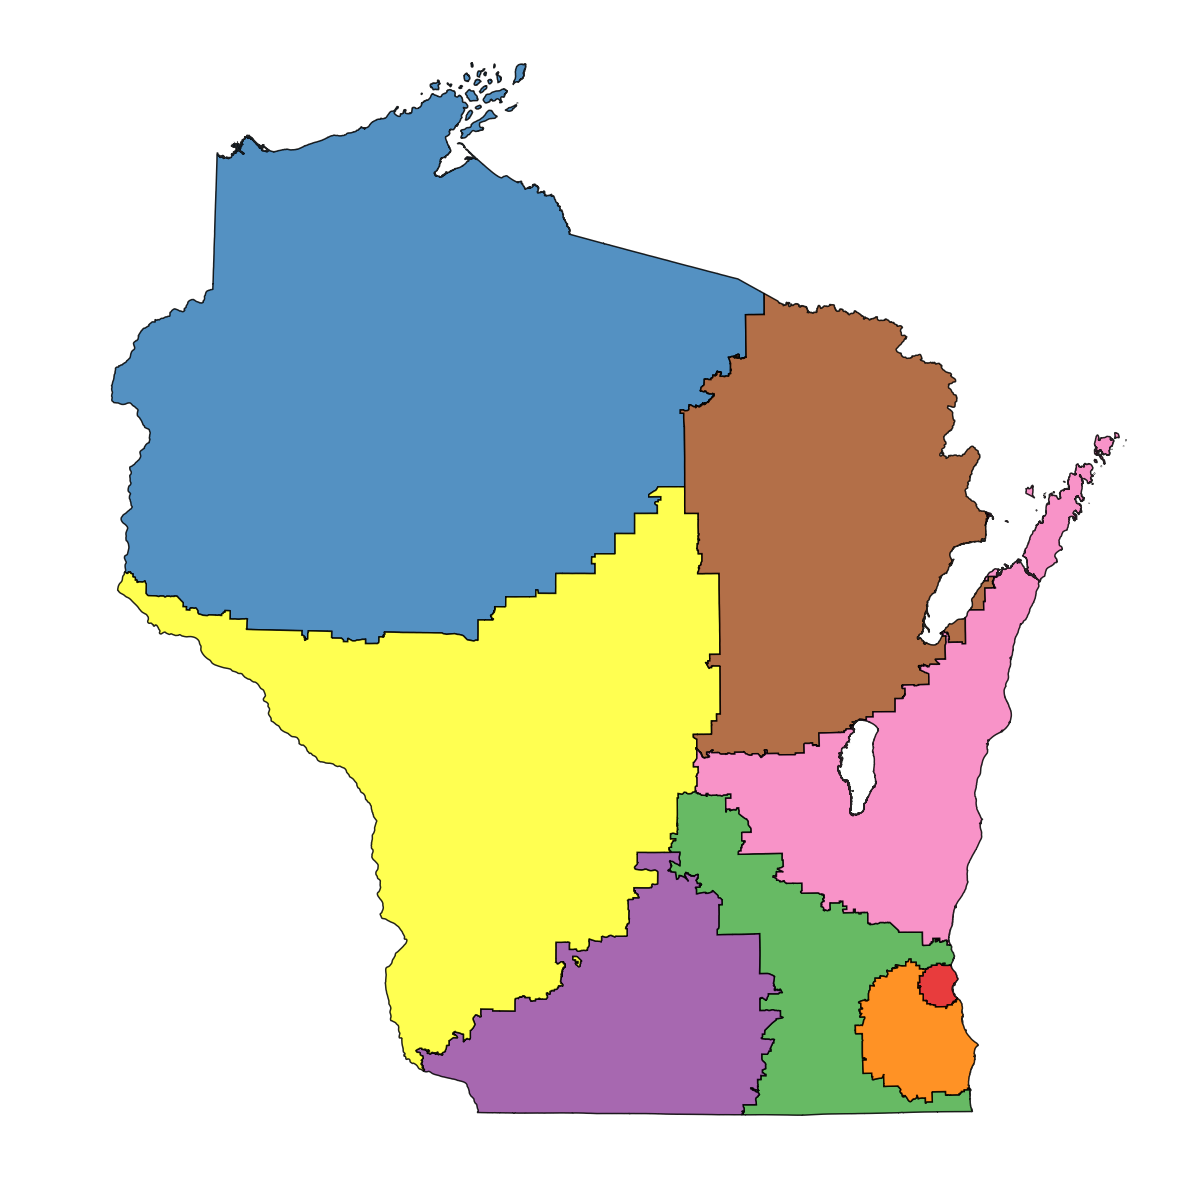

In [348]:
hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
district_colors = [to_rgb(color) for color in hex_colors]

kmeans_file = 'images/samesize_kmeans_test_largest_only.png'
plot_shapes(new_districts, district_colors, fig_file=kmeans_file)

In [222]:
a = np.array([[i,i] for i in range(5)])

In [232]:
a + np.array([1,1])

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5]])

In [229]:
print(np.sum(np.sum(a, axis=1), axis=0))

20
